In [1]:
import sys
sys.path.insert(0, '..')

In [ ]:
from shared.brain_data import load_brain_data
from shared.feature_data import load_feature_data, MITCHELL_ITEM_ORDER
from shared.analysis import doBrainAndFeaturePrediction

In [3]:
load_brain_data_from_s3??

Signature: load_brain_data_from_s3(brain_subject, cache_dir='/tmp')
Source:   
def load_brain_data_from_s3(brain_subject, cache_dir='/tmp'):
    """
    Load brain data for a specific subject from S3

    Args:
        brain_subject: int (1-9) - Which subject's data to load
        cache_dir: str - Directory to cache downloaded files

    Returns:
        dict with brain data (D, meta, sortIdx, voxelReliability, etc.)
    """
    # Create cache directory if needed
    os.makedirs(cache_dir, exist_ok=True)

    # Local cache file
    cache_file = os.path.join(cache_dir, f'data-science-P{brain_subject}_converted.mat')

    # Download from S3 if not cached
    if not os.path.exists(cache_file):
        s3_key = f'brain-data/data-science-P{brain_subject}_converted.mat'
        print(f'Downloading brain data from s3://{BUCKET_NAME}/{s3_key}')
        s3_client.download_file(BUCKET_NAME, s3_key, cache_file)
        print(f'Cached to {cache_file}')
    else:
        print(f'Using cached brain

In [4]:
import scipy.io as sio

brain_subject = 1
filename = f"data-science-P{brain_subject}_converted.mat"
brain_data = sio.loadmat(
    filename,
    squeeze_me=True,
    struct_as_record=True,
    simplify_cells=True
)

# Add subject number to data
brain_data['brain_sub'] = brain_subject
brain_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'meta', 'info', 'data', 'D', 'categoryNum', 'categoryName', 'itemNum', 'itemName', 'sortIdx', 'voxelReliability', 'brain_sub'])

In [5]:
# load_feature_data_from_s3??

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("dopaminemachine_Ratings.csv")
df.head()

,year,groupName,workerId,assignmentId,trialNumber,imageName,itemName,itemCategory,featureName,rating,ratingScaled,ratingScaledMax
0,2020,dopaminemachine,ak,NONE,1,051_celery.jpg,celery,vegetables,animaltype,1,0.0,0.166667
1,2020,dopaminemachine,ak,NONE,2,072_desk.jpg,desk,furniture,animaltype,1,0.0,0.166667
2,2020,dopaminemachine,ak,NONE,3,242_truck.jpg,truck,vehicles,animaltype,1,0.0,0.166667
3,2020,dopaminemachine,ak,NONE,4,032_bottle.jpg,bottle,kitchenUtensils,animaltype,1,0.0,0.166667
4,2020,dopaminemachine,ak,NONE,5,122_house.jpg,house,buildings,animaltype,1,0.0,0.166667


In [7]:
# Get unique values
itemNames = sorted(df.itemName.unique())
featureNames = sorted(df.featureName.unique())
raters = sorted(df.workerId.unique())

numItems = len(itemNames)
numFeatures = len(featureNames)
numRaters = len(raters)

print(f'Found {numItems} items, {numFeatures} features, {numRaters} raters')

# Validate we have all 60 Mitchell items
if numItems != 60:
    raise ValueError(f'Expected 60 items, got {numItems}')

# Initialize ratings matrix
R = np.zeros((numItems, numFeatures))

# Reorder items to match Mitchell's canonical order
itemNames = MITCHELL_ITEM_ORDER.copy()

# Fill in average ratings for each item/feature combination
for itemNum, itemName in enumerate(itemNames):
    for featureNum, featureName in enumerate(featureNames):
        subset = df[(df.itemName == itemName) & (df.featureName == featureName)]
        numRatings = len(subset)
        assert numRatings == numRaters, \
            f'Expected {numRaters} ratings for {itemName}/{featureName}, got {numRatings}'
        # Use ratingScaled (0-1 scale) as in notebook
        R[itemNum, featureNum] = subset.ratingScaled.mean()

feature_data = {
    'R': R,
    'itemNames': np.asarray(itemNames, dtype='object'),
    'featureNames': np.asarray(featureNames, dtype='object')
}

feature_data.keys()

Found 60 items, 16 features, 3 raters


dict_keys(['R', 'itemNames', 'featureNames'])

In [8]:
doBrainAndFeaturePrediction?

Signature:
doBrainAndFeaturePrediction(
    brain_data,
    feature_data,
    num_voxels=500,
    zscore_braindata=False,
    shuffle_features=False,
    testIndividualFeatures=False,
    progress_callback=None,
)
Docstring:
Hold-two-out prediction of brain_data from feature_data (and vice-versa)

This is the main analysis function that runs all 1770 leave-2-out iterations

Args:
    brain_data: dict from load_brain_data_from_s3()
    feature_data: dict from load_feature_data_from_s3()
    num_voxels: int - Number of voxels to use
    zscore_braindata: bool - Whether to z-score brain data
    shuffle_features: bool - Shuffle features (sanity check)
    testIndividualFeatures: bool - Test each feature individually
    progress_callback: Optional function(iteration, total) for progress tracking

Returns:
    dict with:
        - results: dict of lists with all trial results
        - results_by_feature: dict with individual feature results (if enabled)
        - all_betas: list of beta w

In [9]:
# !pip install tqdm

In [10]:
# # Option 2: Use tqdm for nice progress bar
# from tqdm import tqdm

# pbar = tqdm(total=1770, desc="Brain prediction")

# def progress_callback(current, total):
#   pbar.update(1)
  
# results = doBrainAndFeaturePrediction(brain_data, feature_data, num_voxels=500,
#                                       progress_callback=progress_callback)

In [11]:
# results.keys()

In [12]:
# results['results'].keys()

In [13]:
# results['results']['scoring']

In [14]:
# results_df = pd.DataFrame(results['results'])
# results_df

In [15]:
# subset = results_df[(results_df.task=='brain_prediction') & (results_df.method=='encoding_model') & (results_df.scoring=='combo')]
# subset.correct.mean()

In [16]:
# subset = results_df[(results_df.task=='brain_prediction') & (results_df.method=='botastic_templates') & (results_df.scoring=='combo')]
# subset.correct.mean()

In [17]:
# subset = results_df[(results_df.task=='brain_prediction') & (results_df.method=='encoding_model') & (results_df.scoring=='individual')]
# subset.correct.mean()

In [18]:
# subset = results_df[(results_df.task=='brain_prediction') & (results_df.method=='botastic_templates') & (results_df.scoring=='individual')]
# subset.correct.mean()

# Resource profiling for Lambda estimation

In [45]:
import time
import psutil
import os
import sys
import pickle

def get_size_mb(obj):
    """Get size of object in MB using pickle serialization"""
    try:
        size_bytes = len(pickle.dumps(obj, protocol=pickle.HIGHEST_PROTOCOL))
        return size_bytes / (1024 * 1024)
    except Exception as e:
        print(f"Warning: Could not pickle object: {e}")
        return 0

def profile_analysis(brain_data, feature_data, num_voxels=500, testIndividualFeatures=False):
    """
    Run analysis with detailed resource profiling
    
    Returns metrics for Lambda capacity planning
    """
    # Get process for memory monitoring
    process = psutil.Process(os.getpid())
    
    # Record initial state
    initial_memory = process.memory_info().rss / (1024 * 1024)  # MB
    initial_time = time.time()
    
    print("=" * 60)
    print("RESOURCE PROFILING - doBrainAndFeaturePrediction")
    print("=" * 60)
    print(f"\nConfiguration:")
    print(f"  - Brain subject: {brain_data['brain_sub']}")
    print(f"  - Num voxels: {num_voxels}")
    print(f"  - Num features: {len(feature_data['featureNames'])}")
    print(f"  - Test individual features: {testIndividualFeatures}")
    print(f"  - Total iterations: 1770")
    
    print(f"\nInitial state:")
    print(f"  - Memory: {initial_memory:.1f} MB")
    
    # Track peak memory
    peak_memory = initial_memory
    memory_samples = []
    
    # Progress callback that also tracks memory
    from tqdm import tqdm
    pbar = tqdm(total=1770, desc="Analysis progress")
    
    sample_interval = 100  # Sample memory every 100 iterations
    
    def progress_callback(current, total):
        nonlocal peak_memory
        pbar.update(1)
        
        # Sample memory periodically
        if current % sample_interval == 0:
            current_memory = process.memory_info().rss / (1024 * 1024)
            memory_samples.append((current, current_memory))
            peak_memory = max(peak_memory, current_memory)
    
    # Run analysis
    results = doBrainAndFeaturePrediction(
        brain_data,
        feature_data,
        num_voxels=num_voxels,
        zscore_braindata=False,
        testIndividualFeatures=testIndividualFeatures,
        progress_callback=progress_callback
    )
    
    pbar.close()
    
    # Final measurements
    final_time = time.time()
    final_memory = process.memory_info().rss / (1024 * 1024)
    elapsed_time = final_time - initial_time
    
    # Calculate result sizes with debugging
    print("\nCalculating result sizes...")
    results_size = get_size_mb(results['results'])
    print(f"  Results dict: {results_size:.3f} MB ({results_size * 1024:.1f} KB)")
    
    betas_size = get_size_mb(results['all_betas'])
    print(f"  Betas: {betas_size:.3f} MB ({betas_size * 1024:.1f} KB)")
    
    if results['results_by_feature']:
        results_by_feature_size = get_size_mb(results['results_by_feature'])
        print(f"  Results by feature: {results_by_feature_size:.3f} MB ({results_by_feature_size * 1024:.1f} KB)")
    else:
        results_by_feature_size = 0
    
    total_results_size = results_size + betas_size + results_by_feature_size
    
    # Print summary
    print(f"\n{'=' * 60}")
    print("PROFILING RESULTS")
    print("=" * 60)
    
    print(f"\n⏱️  TIMING:")
    print(f"  - Total time: {elapsed_time:.1f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"  - Time per iteration: {elapsed_time/1770:.3f} seconds")
    print(f"  - Iterations per second: {1770/elapsed_time:.2f}")
    
    print(f"\n💾 MEMORY:")
    print(f"  - Initial: {initial_memory:.1f} MB")
    print(f"  - Peak: {peak_memory:.1f} MB")
    print(f"  - Final: {final_memory:.1f} MB")
    print(f"  - Memory increase: {peak_memory - initial_memory:.1f} MB")
    
    print(f"\n📊 RESULT SIZES (serialized):")
    print(f"  - Results dict: {results_size:.2f} MB ({results_size * 1024:.1f} KB)")
    print(f"  - Betas: {betas_size:.2f} MB ({betas_size * 1024:.1f} KB)")
    if results_by_feature_size > 0:
        print(f"  - Results by feature: {results_by_feature_size:.2f} MB")
    print(f"  - Total: {total_results_size:.2f} MB ({total_results_size * 1024:.1f} KB)")
    
    print(f"\n🔢 DATA POINTS:")
    print(f"  - Result rows: {len(results['results']['correct'])}")
    print(f"  - Beta matrices: {len(results['all_betas'])}")
    if len(results['all_betas']) > 0:
        import numpy as np
        beta_shape = np.array(results['all_betas'][0]).shape if results['all_betas'][0] is not None else "None"
        print(f"  - Beta shape (per iteration): {beta_shape}")
    
    # Lambda recommendations
    print(f"\n{'=' * 60}")
    print("LAMBDA RECOMMENDATIONS")
    print("=" * 60)
    
    # Memory recommendation (add safety margin)
    recommended_memory = int((peak_memory * 1.5) / 128) * 128  # Round up to 128MB increments
    recommended_memory = max(1024, min(10240, recommended_memory))  # Clamp to Lambda limits
    
    print(f"\n💾 Memory:")
    print(f"  - Minimum: {int(peak_memory)} MB")
    print(f"  - Recommended: {recommended_memory} MB (with 50% safety margin)")
    
    # Timeout recommendation (add safety margin)
    recommended_timeout = int(elapsed_time * 2)  # 2x safety margin
    recommended_timeout = min(900, recommended_timeout)  # Max 15 minutes
    
    print(f"\n⏱️  Timeout:")
    print(f"  - Observed: {int(elapsed_time)} seconds")
    print(f"  - Recommended: {recommended_timeout} seconds (with 2x safety margin)")
    
    # Performance prediction for different Lambda configs
    print(f"\n⚡ Lambda Performance Estimates:")
    print(f"  Note: Lambda CPU scales with memory allocation")
    print(f"  Your laptop: ~{elapsed_time/60:.1f} minutes")
    
    # Lambda gets 1 vCPU at 1769 MB, scales linearly
    laptop_speed = elapsed_time
    
    for lambda_mem in [1024, 2048, 3008, 10240]:
        # Rough estimate: Lambda is ~0.5-1.0x laptop speed at 2GB
        # CPU scales with memory
        cpu_factor = lambda_mem / 1769  # vCPUs relative to 1769MB baseline
        estimated_time = laptop_speed * 0.8 / cpu_factor  # Assume Lambda ~0.8x laptop at same CPU
        
        if lambda_mem >= recommended_memory and estimated_time <= 900:
            status = "✅"
        elif lambda_mem >= recommended_memory:
            status = "⚠️ "
        else:
            status = "❌"
        
        print(f"  {status} {lambda_mem} MB: ~{estimated_time/60:.1f} min ({estimated_time:.0f}s)")
    
    # Lambda pricing: $0.0000166667 per GB-second
    print(f"\n💰 Cost Estimates (includes compute + request charge):")
    print(f"  Configuration comparison for different memory allocations:\n")
    
    # Price out 1x, 2x, 3x recommended memory
    memory_configs = [
        (recommended_memory, "1x (Recommended)"),
        (min(10240, recommended_memory * 2), "2x (More features)"),
        (min(10240, recommended_memory * 3), "3x (Many features)")
    ]
    
    print(f"  {'Config':<20} {'Memory':<10} {'Est. Time':<12} {'Per Run':<12} {'9 Subjects':<12} {'100 Runs'}")
    print(f"  {'-'*20} {'-'*10} {'-'*12} {'-'*12} {'-'*12} {'-'*10}")
    
    for mem, label in memory_configs:
        # Estimate time based on CPU scaling
        cpu_factor = mem / 1769
        estimated_time = laptop_speed * 0.8 / cpu_factor
        
        # Use estimated time for cost calculation (not the 2x safety timeout)
        gb_seconds = (mem / 1024) * estimated_time
        cost_compute = gb_seconds * 0.0000166667
        cost_request = 0.0000002  # $0.20 per 1M requests
        total_cost = cost_compute + cost_request
        
        print(f"  {label:<20} {mem:>6} MB  {estimated_time/60:>5.1f} min    ${total_cost:>9.6f}  ${total_cost*9:>9.5f}   ${total_cost*100:>9.4f}")
    
    print(f"\n  Note: Costs assume actual execution time, not timeout limit")
    print(f"        Set Lambda timeout to {recommended_timeout}s for safety margin")
    
    return {
        'elapsed_time': elapsed_time,
        'initial_memory': initial_memory,
        'peak_memory': peak_memory,
        'final_memory': final_memory,
        'results_size': total_results_size,
        'recommended_memory': recommended_memory,
        'recommended_timeout': recommended_timeout,
        'memory_samples': memory_samples,
        'results': results
    }

In [46]:
# Run profiled analysis
profile_results = profile_analysis(brain_data, feature_data, num_voxels=500,
                                   testIndividualFeatures=True)

RESOURCE PROFILING - doBrainAndFeaturePrediction

Configuration:
  - Brain subject: 1
  - Num voxels: 500
  - Num features: 16
  - Test individual features: True
  - Total iterations: 1770

Initial state:
  - Memory: 1333.5 MB


Analysis progress:   0%|                                                           | 0/1770 [00:00<?, ?it/s]

ANALYZING SUBJECT NUMBER: 1


Analysis progress: 100%|████████████████████████████████████████████████| 1770/1770 [06:31<00:00,  4.52it/s]



Calculating result sizes...
  Results dict: 2.311 MB (2366.7 KB)
  Betas: 108.101 MB (110695.1 KB)
  Results by feature: 9.458 MB (9684.7 KB)

PROFILING RESULTS

⏱️  TIMING:
  - Total time: 391.3 seconds (6.52 minutes)
  - Time per iteration: 0.221 seconds
  - Iterations per second: 4.52

💾 MEMORY:
  - Initial: 1333.5 MB
  - Peak: 1716.4 MB
  - Final: 1733.9 MB
  - Memory increase: 382.9 MB

📊 RESULT SIZES (serialized):
  - Results dict: 2.31 MB (2366.7 KB)
  - Betas: 108.10 MB (110695.1 KB)
  - Results by feature: 9.46 MB
  - Total: 119.87 MB (122746.5 KB)

🔢 DATA POINTS:
  - Result rows: 14160
  - Beta matrices: 1770
  - Beta shape (per iteration): (500, 16)

LAMBDA RECOMMENDATIONS

💾 Memory:
  - Minimum: 1716 MB
  - Recommended: 2560 MB (with 50% safety margin)

⏱️  Timeout:
  - Observed: 391 seconds
  - Recommended: 782 seconds (with 2x safety margin)

⚡ Lambda Performance Estimates:
  Note: Lambda CPU scales with memory allocation
  Your laptop: ~6.5 minutes
  ❌ 1024 MB: ~9.0 min

In [47]:
profile_results['results'].keys()

dict_keys(['results', 'results_by_feature', 'all_betas'])

In [48]:
results_df = pd.DataFrame(profile_results['results']['results'])
results_df
# Get total memory usage in MB
size_mb = results_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"DataFrame size: {size_mb:.2f} MB")

DataFrame size: 8.18 MB


In [49]:
results_df = pd.DataFrame(profile_results['results']['results_by_feature'])
results_df
# Get total memory usage in MB
size_mb = results_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"DataFrame size: {size_mb:.2f} MB")

DataFrame size: 36.63 MB


In [41]:
results_df.head()

,feat_num,feat_name,brain_subject,item1_idx,item2_idx,item1_name,item2_name,item1_cat,item2_cat,itemPair,same_category,r2_score,task,method,scoring,dist11,dist22,dist12,dist21,correct
0,0,animaltype,1,0,1,bear,cat,animal,animal,"(0, 1)",1,0.045719,brain_prediction,encoding_model,individual,0.418963,0.424888,0.424888,0.418963,0.5
1,0,animaltype,1,0,1,bear,cat,animal,animal,"(0, 1)",1,0.045719,brain_prediction,encoding_model,combo,0.418963,0.424888,0.424888,0.418963,0.0
2,1,clothing,1,0,1,bear,cat,animal,animal,"(0, 1)",1,0.026539,brain_prediction,encoding_model,individual,1.004322,1.256569,1.256569,1.004322,0.5
3,1,clothing,1,0,1,bear,cat,animal,animal,"(0, 1)",1,0.026539,brain_prediction,encoding_model,combo,1.004322,1.256569,1.256569,1.004322,0.0
4,2,container,1,0,1,bear,cat,animal,animal,"(0, 1)",1,0.062729,brain_prediction,encoding_model,individual,0.825968,0.697560,0.697560,0.825968,0.5


In [34]:
# results_df

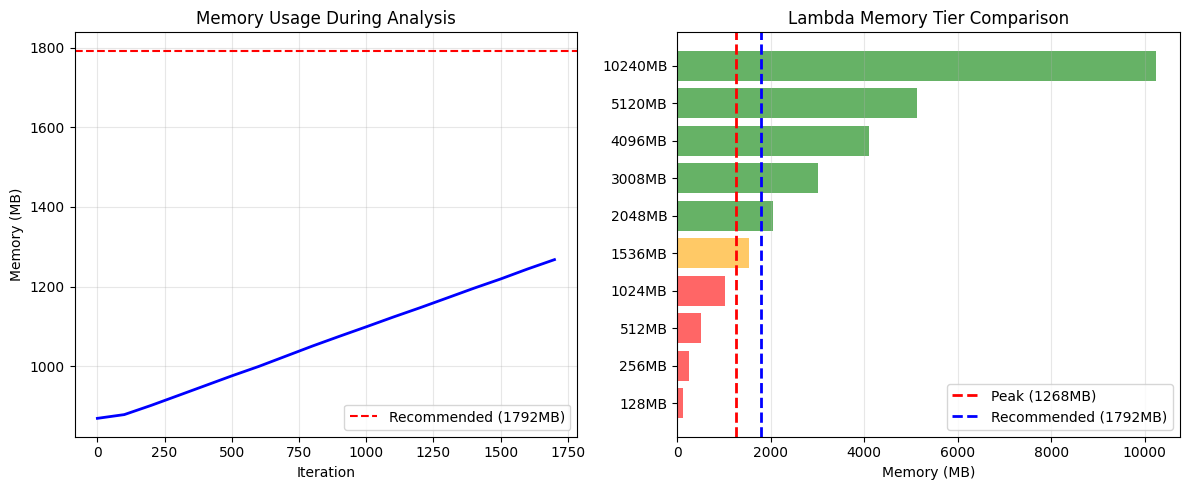


📈 Memory growth rate: 0.229 MB per iteration


In [43]:
# Visualize memory usage over time
import matplotlib.pyplot as plt

if profile_results['memory_samples']:
    iterations, memory = zip(*profile_results['memory_samples'])
    
    plt.figure(figsize=(12, 5))
    
    # Memory over time
    plt.subplot(1, 2, 1)
    plt.plot(iterations, memory, 'b-', linewidth=2)
    plt.axhline(y=profile_results['recommended_memory'], 
                color='r', linestyle='--', label=f"Recommended ({profile_results['recommended_memory']}MB)")
    plt.xlabel('Iteration')
    plt.ylabel('Memory (MB)')
    plt.title('Memory Usage During Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Lambda memory tiers
    plt.subplot(1, 2, 2)
    lambda_tiers = [128, 256, 512, 1024, 1536, 2048, 3008, 4096, 5120, 10240]
    lambda_tiers = [t for t in lambda_tiers if t <= 10240]
    
    peak = profile_results['peak_memory']
    recommended = profile_results['recommended_memory']
    
    colors = ['red' if t < peak else 'orange' if t < recommended else 'green' for t in lambda_tiers]
    
    plt.barh(range(len(lambda_tiers)), lambda_tiers, color=colors, alpha=0.6)
    plt.axvline(x=peak, color='red', linestyle='--', linewidth=2, label=f'Peak ({peak:.0f}MB)')
    plt.axvline(x=recommended, color='blue', linestyle='--', linewidth=2, label=f'Recommended ({recommended}MB)')
    
    plt.yticks(range(len(lambda_tiers)), [f'{t}MB' for t in lambda_tiers])
    plt.xlabel('Memory (MB)')
    plt.title('Lambda Memory Tier Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Memory growth rate: {(peak - profile_results['initial_memory'])/1770:.3f} MB per iteration")